# Fashion-MNIST Image Classification

In this notebook, I am going to develop a simple convolutional neural network model for image classification on the Fashion-MNIST dataset. The contents within are an extension of a coursework for module 316, Computer Vision at Imperial College.

In [2]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
import time
import random
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


# Step 1 - Load and visualise data

The Fashion-MNIST dataset is the focal dataset of the below paper.

[1] Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747): Han Xiao, Kashif Rasul, Roland Vollgraf. 

The dataset is very much similar to the standard MNIST dataset in terms of format and features but instead focuses on a small collection of accessories. The dataset is split into sets of 60,000 training images and 10,000 test images. The images are all of size 28x28 pixels.

There 10 total label classes:
* 0 -> T-shirt/top
* 1 -> Trousers
* 2 -> Pullover
* 3 -> Dress
* 4 -> Coat
* 5 -> Sandal
* 6 -> Shirt
* 7 -> Sneaker
* 8 -> Bag
* 9 -> Ankle boot

In [3]:
# This is a purely model-based implementation and so no data augmentation will be added.
training_set = torchvision.datasets.FashionMNIST(root='.', download=True, 
                                                 train=True, 
                                                 transform=transforms.Compose(
                                                     [transforms.ToTensor()])
                                                )

training_images = np.array(training_set.data)
training_labels = np.array(training_set.targets)
class_names = training_set.classes

test_set = torchvision.datasets.FashionMNIST(root='.', download=True, 
                                             train=False, 
                                             transform=transforms.Compose(
                                                 [transforms.ToTensor()])
                                            )
test_images = np.array(test_set.data)
test_labels = np.array(test_set.targets)


### 1.1 Inspect the dimension of the training and test sets

In [4]:
# The dimensions of each set are the number of samples along the first dimension
print("Training Set Label Dimension:", training_labels.shape)
print("Training Set Image Dimension:", training_images.shape)
print("Test Set Label Dimensions:", test_labels.shape)
print("Test Set Image Dimensions:", test_images.shape)


Training Set Label Dimension: (60000,)
Training Set Image Dimension: (60000, 28, 28)
Test Set Label Dimensions: (10000,)
Test Set Image Dimensions: (10000, 28, 28)


### 1.2 Visualise sample images for each of the 10 classes

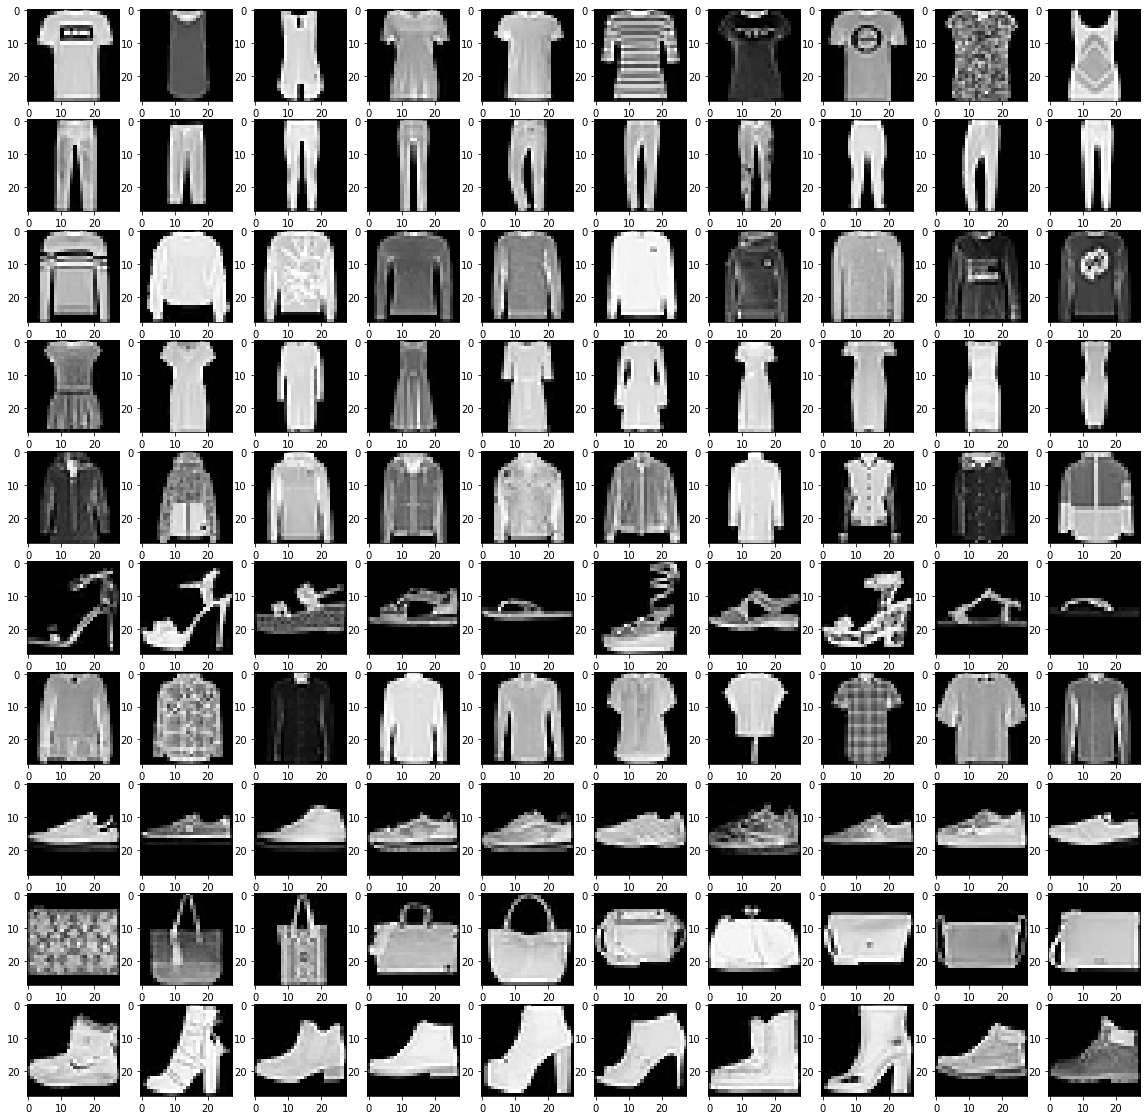

In [5]:
# Create an array to hold all images for each class 0-9
class_images = [[] for _ in range(10)]

# Fill up class_images with images from training_images and labels from training_labels
for i, img in enumerate(training_images):
    label = training_labels[i]
    class_images[label].append(img)

# Turn into numpy array for ease of processing later    
class_images = np.array(class_images)

# Create output grid and plot first 10 images for each class
_, ax = plt.subplots(10, 10, figsize=(20,20))
for row in range(10):
    items = class_images[row]
    for col in range(10):
        ax[row][col].imshow(items[col], cmap='gray')


### 1.3 Display the number of training samples for each class

In [7]:
print("Training Sample Class Counts:")
for i, items in enumerate(class_images):
    print("\tClass", i, "-", len(items))


Training Sample Class Counts:
	Class 0 - 6000
	Class 1 - 6000
	Class 2 - 6000
	Class 3 - 6000
	Class 4 - 6000
	Class 5 - 6000
	Class 6 - 6000
	Class 7 - 6000
	Class 8 - 6000
	Class 9 - 6000


### 1.4 Discussion on representation of the training set 

The dataset is balanced. As we can see from the above output, all 10 classes have the same number of samples. Thankfully this is what we expect, as we can read from the paper, "The training set receives a randomly-selected 6,000 examples from each class".

If the dataset were to be unbalanced, this could affect the accuracy of our classifier. It could sway the classifier to favour the oversampled majority class and not put enough weighting towards a minority class. We aim to maintain balance so that the classifier can learn characteristics of each class equally, (unless there is a pragmatic imbalance in the true underlying distribution).

## 2. Convolutional Neural Network Implementation


Here we design a convolutional neural network (CNN) architecture, such as the famous LeNet architecture (shown below). The architecture consists of a number of convolutional layers and a few fully connected layers, with various regularising layers in between. We then use the CNN to classify the Fashion-MNIST dataset.

![](lenet.png)

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
                
        # Convolutional Layers
        # Start with 1 channel as images are grayscale, then gradually scale out
        # Pad on the first two to find border features, then scale down
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) 
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        
        # Full Connection MLP Linear Layers
        self.mlp1 = nn.Linear(in_features=64*5*5, out_features=256)
        self.mlp2 = nn.Linear(in_features=256, out_features=128)
        
        # Output MLP Linear Layer
        self.out = nn.Linear(in_features=128, out_features=10)
        
        # Non-Linear Activation Function
        # Use relu for its simplicity and ease of computation 
        # After testing, using LeakyReLu & ELU has no visible benefits
        self.activ = F.relu
        
        # Dropout Layers
        self.drop1 = nn.Dropout(p=0.2) # Low probability early to maintain information
        self.drop2 = nn.Dropout(p=0.3)
        self.drop3 = nn.Dropout(p=0.4) # Higher probability later to reduce overfitting
        
        # Normalization Layers
        self.norm1 = nn.BatchNorm2d(64)
        self.norm2 = nn.BatchNorm1d(128)
    
    def forward(self, x):
        x = self.conv1(x) # (28,28,32)
        x = self.activ(x)
        x = self.conv2(x) # (28,28,32) - padding
        x = self.activ(x)
        
        x = F.max_pool2d(x, kernel_size=2, stride=2) # (14,14,32)
        x = self.drop1(x) # Dropout only after pool
        
        x = self.conv3(x) # (12,12,64) - no padding
        x = self.activ(x)
        x = self.conv4(x) # (10,10,64)
        x = self.activ(x)
        
        x = self.norm1(x) # Normalize only after non-linear activation
        x = F.max_pool2d(x, kernel_size=2, stride=2) # (5,5,64)
        x = self.drop2(x)
        
        # Flatten the tensor to pass it through to MLP
        x = x.reshape(-1, 64*5*5)
        
        x = self.mlp1(x) # (1600 => 256)
        x = self.activ(x)
        x = self.mlp2(x) # (256 => 128)
        x = self.activ(x)
        
        x = self.norm2(x)
        x = self.drop3(x)
        
        # Output Layer
        # We don't need to use softmax as CrossEntropyLoss later does this internally
        return(self.out(x))


### 2.2 Define the loss function, optimiser and hyper-parameters

In [11]:
# All of these values were extensively tested and tuned through a 
# variety of methods to give optimal results (code removed for clarity).

# Trade-off for time vs accuracy as the accuracy curve flattens here.
# At higher values, we get minor fluctuating accuracy improvements, 
# but significant time increase, based on results seen in 2.5.
epochs = 15
# Medium batching size balances time vs accuracy
batch_size = 128 
# Found to be fastest and most accurate lr for Adam
learning_rate = 0.001

cnn = CNN()

loss_func = nn.CrossEntropyLoss()  # Performs softmax internally
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)


### 2.3 Start model training

At each iteration, get a random batch of images and labels from training_images and training_labels, convert them into torch tensors, feed them into the network model and perform gradient descent.

In [12]:
# Shuffle the training data to get a new random distribution each epoch
training_loader = torch.utils.data.DataLoader(dataset=training_set,
                                              batch_size=batch_size,
                                              shuffle=True
                                             )

# Set CNN to train mode (enable dropout and mutable gradients)
cnn.train()

start = time.time()
for epoch in range(epochs):
    # Perform epoch over several batches
    for (images, labels) in training_loader:        
        # Forward pass & predictions
        predictions = cnn(images)
        
        # The loss is normalized internally for the batch 
        loss = loss_func(predictions, labels)
        
        optimizer.zero_grad() # Reset optimizer gradients
        loss.backward() # Backpropagate new gradients
        optimizer.step() # Optimize using adam

total = time.time() - start
print("Total Training Time, (s):", round(total, 4))
print("Average Time Per Epoch, (s):", round(total / epochs, 4))

# The training time is quite large but is justifiable by the increase 
# in accuracy gained by performing some extra epochs, as seen in 2.5.


Total Training Time, (s): 921.4275
Average Time Per Epoch, (s): 61.4285


### 2.4 Deploy the trained model on the test set

In [13]:
# shuffle=False, so the confusion matrix is in the correct order
testing_loader = torch.utils.data.DataLoader(dataset=test_set,
                                             batch_size=batch_size,
                                             shuffle=False
                                            )

def deploy_model():
    correct = 0 # Number of correct predictions
    predictions = np.array([])

    start = time.time()
    for images, labels in testing_loader:
        # Get softmax output and extract predictions by taking
        # the largest softmax class probability using torch.max
        outputs = cnn(images)
        _, predicted_classes = torch.max(outputs.data, 1)
        predictions = np.append(predictions, predicted_classes)  
        
        # Running total of correct predictions
        correct += (predicted_classes.data==labels.data).sum()
        
    # Accuracy as a percentage
    accuracy = round(100 * (correct.item() / len(test_set)), 5)
    # Total testing time
    test_time = time.time() - start
    
    return accuracy, predictions, test_time


### 2.5 Evaluate the classification accuracy on the test set

Final Test Accuracy: 93.53%
Total Testing Time, (s): 3.1837


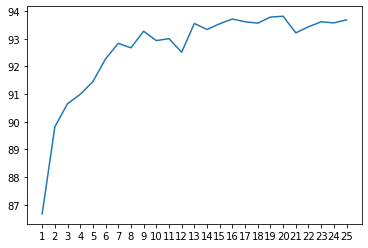

In [14]:
# Set CNN to evaluation mode (disable dropout and mutable gradients)
cnn.eval()

# Final accuracy, predictions and test runtime
accuracy, predictions, runtime = deploy_model()

print("Final Test Accuracy:", str(accuracy) + "%")
print("Total Testing Time, (s):", round(runtime, 4))


# For the reader's interest, deciding on optimal epochs:
# Averaged test-set accuracy of 25 epochs over 3 runs, (epoch, accuracy):
# (Calculated from code removed after hyperparameter tuning)

# 01 - 86.67%  # 02 - 89.82%  # 03 - 90.65%  # 04 = 90.99%  # 05 = 91.45%
# 06 - 92.27%  # 07 - 92.83%  # 08 - 92.67%  # 09 = 93.27%  # 10 = 92.93%
# 11 - 93.00%  # 12 - 92.51%  # 13 - 93.55%  # 14 = 93.33%  # 15 = 93.54%
# 16 - 93.71%  # 17 - 93.61%  # 18 - 93.56%  # 19 = 93.78%  # 20 = 93.81%
# 21 - 93.21%  # 22 - 93.43%  # 23 - 93.61%  # 24 = 93.57%  # 25 = 93.68%

accs = [86.67, 89.82, 90.65, 90.99, 91.45, 92.27, 92.83, 92.67, 93.27, 
        92.93, 93.00, 92.51, 93.55, 93.33, 93.54, 93.71, 93.61, 93.56,
        93.78, 93.81, 93.21, 93.43, 93.61, 93.57, 93.68]

# Plot pre-calculated accuracies for performance description
# The accuracy steadies out and fluctuates less after around 15 epochs
# N.B. Loss is very similar to this but in a negative trend.
plt.plot(range(1, 26), accs)
plt.xticks(np.arange(1, 26, 1.0))
plt.show()


### 2.6 Visualise the confusion matrix

In [15]:
metrics.confusion_matrix(test_set.targets, predictions)

# We can see a fairly consistent trend of poor recall and precision 
# for class 6. It is often misclassified as class 0 and only gets 
# about 3/4 correct. This is understandable as shirts and t-shirt 
# are visually very similar. Most of the other classes are fairly 
# accurate which makes sense given 93%+ accuracy.


array([[900,   0,  15,  10,   1,   0,  71,   0,   3,   0],
       [  1, 985,   0,   8,   2,   0,   2,   0,   2,   0],
       [ 14,   0, 913,   9,  29,   0,  35,   0,   0,   0],
       [ 10,   0,   7, 936,  27,   0,  19,   0,   1,   0],
       [  1,   0,  26,  18, 905,   0,  50,   0,   0,   0],
       [  0,   0,   0,   0,   0, 986,   0,   9,   0,   5],
       [ 86,   0,  48,  20,  46,   0, 796,   0,   4,   0],
       [  0,   0,   0,   0,   0,   6,   0, 978,   0,  16],
       [  4,   0,   2,   2,   2,   2,   3,   2, 983,   0],
       [  1,   0,   0,   0,   0,   5,   0,  23,   0, 971]])

## 3. Deploy in real world

Using 3 photos taken by myself, I have converted them into grayscale, negated the intensities so that background becomes dark, cropped the region of interest and finally reshaped them into size 28x28 pixels.

I will then visualise them, before running them through my classifier.

### 3.1 Load and visualise the real images

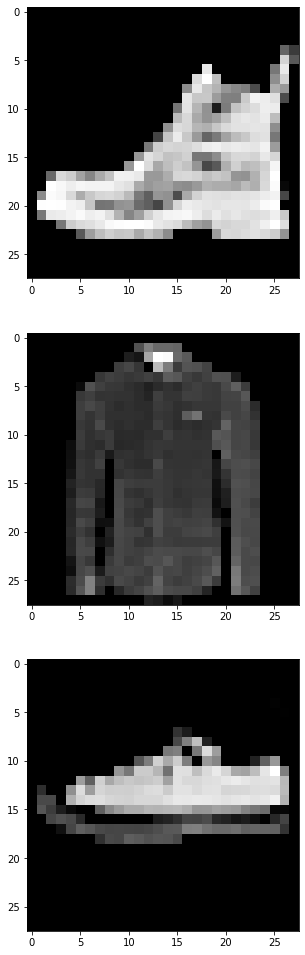

In [16]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1), 
                                transforms.ToTensor()])
custom_test_set = torchvision.datasets.ImageFolder(
    root='./images',
    transform=transform
)

# Create output grid and plot the three images
_, ax = plt.subplots(3, figsize=(17,17))
for i, image in enumerate(custom_test_set):
    ax[i].imshow(image[0][0], cmap='gray')  # Plot in grayscale


### 3.2 Test the network on the real images

In [17]:
custom_loader = torch.utils.data.DataLoader(dataset=custom_test_set,
                                            batch_size=3,
                                            shuffle=False)

# Set CNN to evaluation mode (disable dropout and mutable gradients)
cnn.eval()

# Ankle Boot - 9, Shirt - 6, Sneaker - 7
ground_truths = np.array([9, 6, 7])

# Evaluate the predictions as in 2.4 using softmax and torch.max
preds = np.array([])
for images, _ in custom_loader:
    output = cnn(images)
    _, predicted_classes = torch.max(output.data, 1)
    preds = np.append(preds, predicted_classes) 
num_correct = (preds==ground_truths).sum()

for i, val in enumerate(ground_truths):
    print("Class", val, "predicted as class", preds[i])
print("\nTotal Number Correct:", num_correct, "out of 3")


Class 9 predicted as class 9.0
Class 6 predicted as class 6.0
Class 7 predicted as class 7.0

Total Number Correct: 3 out of 3


### 3.3 Discussion of classification results

My model seems to work generally very accurately on the custom provided images, with an accuracy echoing that of the test set. Over multiple runs there are occasions where I get 2/3 but generally I get 3/3 with the fully trained model.

The reason for this is that mistakes are commonly made distinguishing visually similar items. For example, a low quality 28x28 sneaker can be misclassified as a sandal, or a pullover misclassified as a coat. It is very hard even as a human to distinguish some of these images at such low quality, so I think that 93%+ accuracy is quite good.

The cases in which there are incorrect results in my provided images could partly be due to the fact that the Fashion-MNIST images were all taken in a standard format from a website, "shot by professional photographers... with a light-gray background". My photos are taken with a different background and probably a lower quality camera, which might not capture some of the finer details of the objects.

It is worth nothing that I have not performed such thorough pre-processing as the writers of the paper would have. For example I don't perform any gaussian sharpening or probabilistic trimming based on intensity. This would greatly increase the quality of the pictures and match them more accurately to the trained model.

The robustness of the model for real-life performance could be increased by widening the training dataset with more imperfect examples like my provided images without such a standardised format.